# Introduction
The goal of this notebook is to calibrate Monarch to match experimental baseline/acute volume overload data from Nakano et al. 1991. Subsequently, the fitted growth parameters from the calibration notebook will be utilized to predict the chronic MVR outcome. This notebook has two parts: 
1. Fitting the cardiac and hemodynamic parameters to match baseline (pre-MVR) and acute-MVR models
2. Validating growth parameters by predicting the chronic (post-MVR) response

In [1]:
import pathlib
import pandas as pd

# Get notebook directory and store everything in a subdirectory
root_dir = pathlib.Path().absolute()
data_dir = root_dir / "data_nakano"
baseline_dir = root_dir / "nakano_baselineacute"
growth_dir = root_dir / "nakano_growth"

# Import csv file data as pandas dataframe and first column as index
data_baseline = pd.read_csv(data_dir / "data_baselineacute.csv", index_col=0)

# Model properties
input_file = root_dir.parent / "inputs" / "input_nakano"
model_constants = {"HR": 62, "HR_acute": 118, "AmRefRfwRatio": 1.36, "AmRefSwRatio": 0.53, "AmRefLARatio": 0.70,
                       "AmRefRARatio": 0.51, "RfWth": 3.4, "LAWth": 3.9, "RAWth": 3.9, "SWth": 10.3}


# Enable automatically reloading modules when they have changed
%load_ext autoreload
%autoreload 2

When rerunning this notebook, set the run_sims variable to false to skip the simulation step and only run the GPEs and implausibility calculations. Simulations ran previously will be loaded and this will tremendously speed up the process.

In [2]:
run_sims = True

# Fitting the baseline model
## Setting up the Wave class
We will use the Wave class to fit the baseline/acute model. This class is designed to fit a model to a set of data points using Bayesian History Matching. First, we decide what parameters to fit and what their expected ranges are, and compile them in a list of dictionaries (one for each parameter). It is important that the labels match (case-insensitive) the label names in the monarch change_pars function.

In [3]:
pars = {
        "SAct": {"limits": [0.050, 0.200]},
        "AmRefLfw": {"limits": [4e3, 10e3]},
        "VLfw": {"limits": [40e3, 70e3]},
        "SBV": {"limits": [300, 1500]},
        "Ras": {"limits": [0.3, 5.0]},
        "SBV_acute": {"limits": [300, 1500]},
        "Ras_acute": {"limits": [0.3, 8.0]},
        "Rmvb_acute": {"limits": [0.05, 2.0]}
    }

## Running a full BHM scheme

We now run the entire BHM process, this will take several minutes, depending on your computer. Note that many simulation in the early waves will crash because some very unrealistic parameter sets are included, but in later waves the model will behave much better since only non-implausible parameters sets are retained.

In [4]:
from chameleon.camouflage import Camouflage
import chameleon.monarch_utils as model_utils
from chameleon.colors import TrueColors
import pandas as pd

# Initialize wave index
i_wave = 0
nroy = None
not_flooded = True
sim_dirs = []

# Start history matching until convergence is reached
while not_flooded:

    # Set wave threshold: start with 5.0 and reduce incrementally with steps of 0.5 until 2.0
    wave_threshold = max(5 - 1*i_wave, 2)
    
    # Initialize wave    
    camo = Camouflage(i_wave, baseline_dir, wave_threshold, pars, data_baseline, nroy=nroy, clear_log=(i_wave == 0), 
                constants=model_constants)

    # Run simulations for all parameter sets in current wave set
    camo.x_sim, camo.y_sim, sim_dirs = model_utils.run_forest_run(camo, input_file, sim_dirs, constants=model_constants, 
                                                                  log_file=camo.log_file, run_sims=run_sims)

    # Run wave: train/validate emulators, emulate, calculate implausibility, find NROY
    camo.surf()

    # Check for convergence, store NROY from this wave as NROY for the next wave and update counter
    not_flooded = camo.is_flooded(i_wave, min_waves=4, max_waves=5)
    nroy = camo.nroy
    i_wave += 1

-----------
Parameters:
-----------
- SAct: [0.05 - 0.2]
- AmRefLfw: [4000.0 - 10000.0]
- VLfw: [40000.0 - 70000.0]
- SBV: [300.0 - 1500.0]
- Ras: [0.3 - 5.0]
- SBV_acute: [300.0 - 1500.0]
- Ras_acute: [0.3 - 8.0]
- Rmvb_acute: [0.05 - 2.0]


-------------
Observations:
-------------
- LVEDV: 68.0 ± 6.8
- LVEF: 0.54 ± 0.03
- LVEDP: 5.7 ± 0.5
- SBP: 110.0 ± 4.6
- EDWthLfw: 8.1 ± 0.4
- LVEDV_acute: 83.0 ± 5.1
- LVEF_acute: 0.67 ± 0.023
- LVEDP_acute: 22.0 ± 1.5
- SBP_acute: 108.0 ± 7.1
- LVRF_acute: 0.62 ± 0.04


-------------
Constants:
-------------
- HR: 62
- HR_acute: 118
- AmRefRfwRatio: 1.36
- AmRefSwRatio: 0.53
- AmRefLARatio: 0.7
- AmRefRARatio: 0.51
- RfWth: 3.4
- LAWth: 3.9
- RAWth: 3.9
- SWth: 10.3



------
Wave 1
------
Generated emulation point cloud with 1048576 points
Running 128 model simulations...


/Users/beatlab/Projects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/beatlab/Projects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/beatlab/Projects/monarch/src/monarch/heart.py:307: RuntimeWarning: invalid value encountered in scalar power
  r_m = ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3)


128 simulation pairs (baseline + acute) completed in 20.13 seconds
126 Simulations reached convergence
93 Simulations added to training data
Training GPEs using PyTorch...
Emulating 1048576 points...
Emulation completed in 6.57 seconds
209309 points remaining in NROY region (19.96% of original space)
LVEDV is the most implausible output (28.08% of all points)
183137 points remaining in NROY region after limits check
NROY size change at Wave 1 is -0.83: no convergence

------
Wave 2
------
Running 128 model simulations...


/Users/beatlab/Projects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/beatlab/Projects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/beatlab/Projects/monarch/src/monarch/heart.py:307: RuntimeWarning: invalid value encountered in scalar power
  r_m = ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3)


128 simulation pairs (baseline + acute) completed in 20.29 seconds
126 Simulations reached convergence
107 Simulations added to training data
Training GPEs using PyTorch...
Emulating 183137 points...
Emulation completed in 1.33 seconds
4525 points remaining in NROY region (0.43% of original space)
LVEDP is the most implausible output (21.5% of all points)
3821 points remaining in NROY region after limits check
NROY size change at Wave 2 is -0.98: no convergence

------
Wave 3
------
Regenerating emulation cloud from 3821 to 100000 points...
Running 128 model simulations...
128 simulation pairs (baseline + acute) completed in 18.45 seconds
127 Simulations reached convergence
102 Simulations added to training data
Training GPEs using PyTorch...
Emulating 100000 points...
Emulation completed in 1.33 seconds
1679 points remaining in NROY region (0.16% of original space)
SBP is the most implausible output (17.7% of all points)
1656 points remaining in NROY region after limits check
NROY siz

/Users/beatlab/Projects/monarch/src/monarch/egg.py:137: RuntimeWarning: divide by zero encountered in divide
  self.volumes[0, :] = self.volumes[-1, :] * self.circulation.sbv / np.sum(self.volumes[-1, :])


128 simulation pairs (baseline + acute) completed in 18.08 seconds
125 Simulations reached convergence
105 Simulations added to training data
Training GPEs using PyTorch...
Emulating 100000 points...
Emulation completed in 1.73 seconds
862 points remaining in NROY region (0.08% of original space)
LVEF_acute is the most implausible output (18.21% of all points)
862 points remaining in NROY region after limits check
NROY size change at Wave 4 is -0.48: no convergence

------
Wave 5
------
Regenerating emulation cloud from 862 to 100000 points...
Running 128 model simulations...
128 simulation pairs (baseline + acute) completed in 17.85 seconds
128 Simulations reached convergence
112 Simulations added to training data
Training GPEs using PyTorch...
Emulating 100000 points...
Emulation completed in 2.27 seconds
15820 points remaining in NROY region (1.51% of original space)
SBP is the most implausible output (16.54% of all points)
15820 points remaining in NROY region after limits check
NR

## Analyzing the results
Run and plot simulations using a randomly selected subset of the posterior distribution. Compare these results with the simulation results after we just ran the single wave with implausibility criterion of 5.0 to see the vast improvement.


---------
Posterior
---------
Running 256 model simulations...
256 simulation pairs (baseline + acute) completed in 26.55 seconds
256 Simulations reached convergence
246 Simulations added to training data


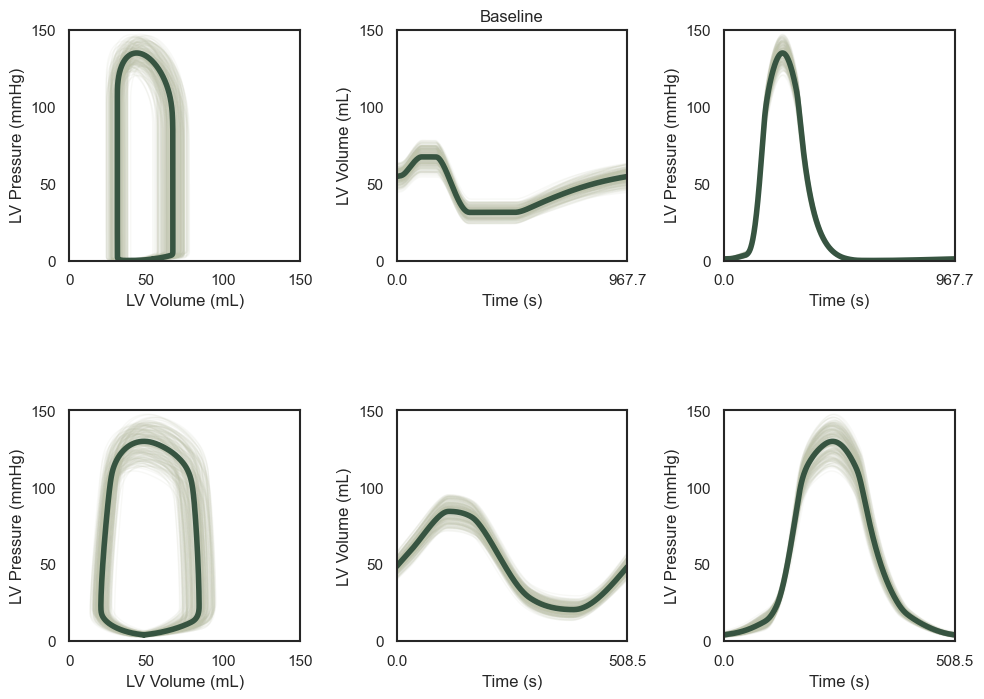

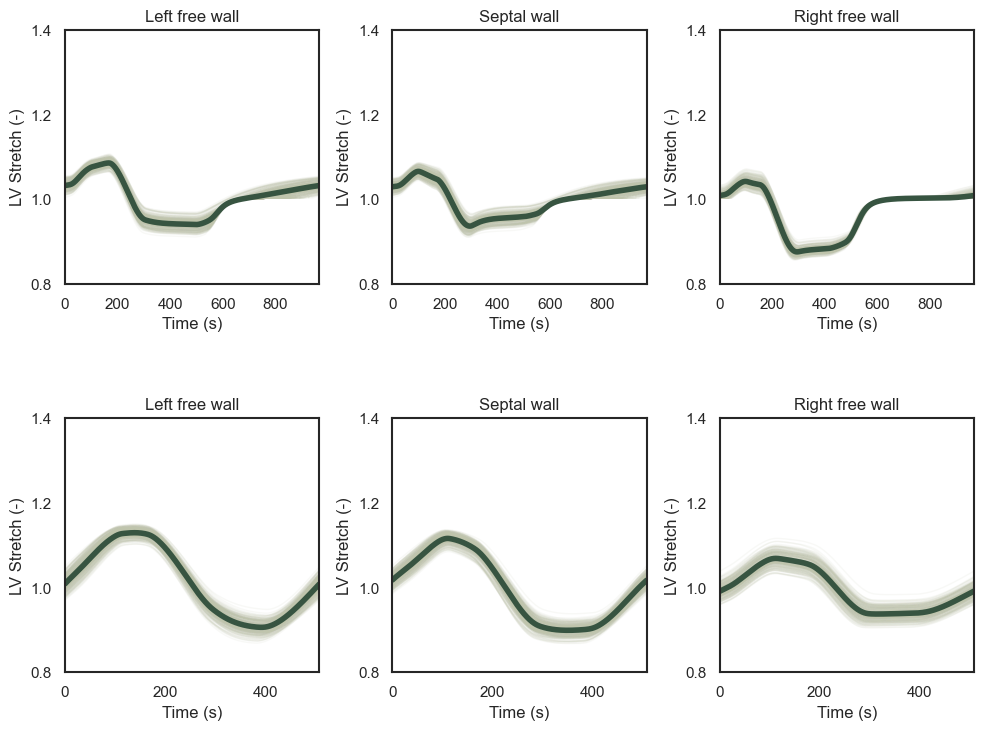

In [5]:
# Run simulations for all parameter sets in current wave set
x_posterior, y_posterior, _ = model_utils.run_forest_run(camo, input_file, [],  constants=model_constants, 
                                                         log_file=camo.log_file, show_fig=True, posterior=True)

In [6]:
camo.x_posterior, camo.y_posterior = x_posterior, y_posterior
camo.pickle_wave()

Now start the Tide class to further analyze the results. This class is designed to analyze the progression and final results of the fitting scheme. Because the Tide class is only dependent on the exported results from the Wave class, the following cell and all others in this section can be run independently of the rest of the notebook. First, always check if the final NROY region is within the 95% confidence interval of all data:

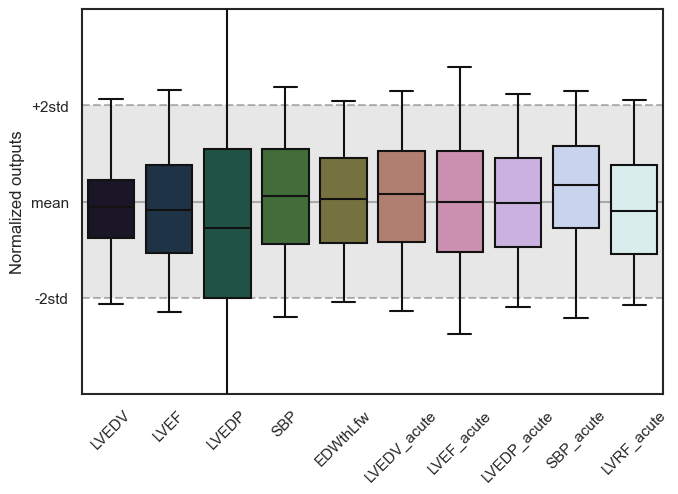

In [7]:
from chameleon.colors import TrueColors

colors = TrueColors(baseline_dir)

# Plot the convergence of the implausibility
colors.plot_nroy_data(show_box = True)

Next, inspect the final NROY region to inspect if all parameters are uniquely fitted, and if the mean of the matched distribution is close to the true values in this synthetic case. This plot is time-consuming to generate, so we here run it with a subset of 1000 randomly chosen parameter sets.

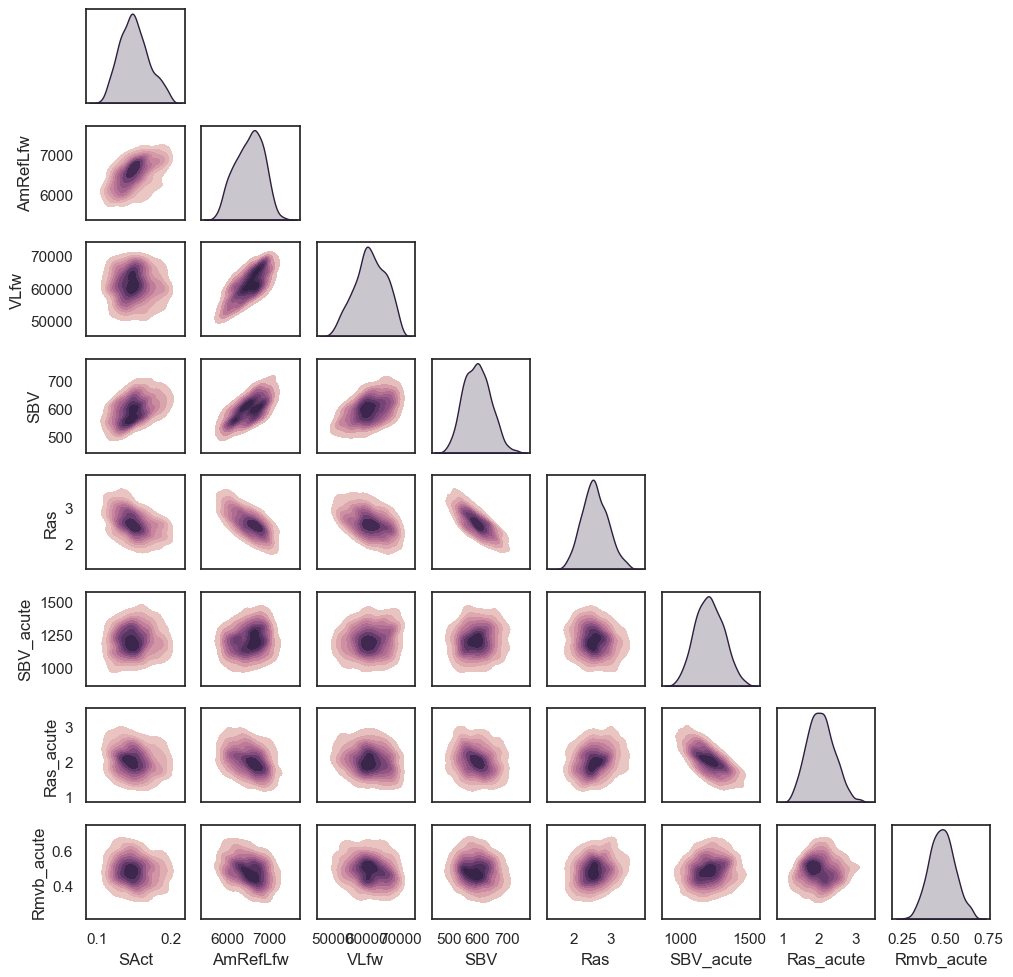

In [8]:
colors.plot_nroy_x(n_samples=1000, show_fig=True)

Run all plots, this will be time-consuming–in fact, it is slower than running BHM itself! The plots are saved in the *results* subdirectory.

In [9]:
import matplotlib.pyplot as plt
plt.close("all")
colors.roll(nroy_full=False)

# Validating the growth model
## Utilizing the previously calibrated growth model to predict growth in this study


In [14]:
import numpy as np 
import pandas as pd

data = pd.read_csv(data_dir / "data_growth.csv", index_col=0)

model_constants.update(
                {"tau_f-": 1e5, "tau_r+": 1e5, "theta_f_max": 1.5 ** 2, "theta_f_min": 0.9 ** 2,
                 "gamma": 2.0, "theta_r_max": 1.5, "theta_r_min": 0.75, "t_mem": 1e5})
model_constants.update(
                {"theta_f_max": 1e5, "theta_f_min": 0,
                 "theta_r_max": 1e5, "theta_r_min": 0})

# Initialize wave
camo = Camouflage(0, growth_dir, 1, pars, data, nroy=nroy, clear_log=(i_wave == 0),
                    constants=model_constants, validation=True)


------
Wave 1
------
Regenerating emulation cloud from 15820 to 100000 points...


In [15]:
# Obtain the posterior distributions from the stored baseline and growth models
pickle_file_baseline = pathlib.Path(root_dir / 'nakano_baselineacute' / 'Wave 5' / 'wave.pkl')
pickle_file_growth = pathlib.Path(root_dir / 'kleaveland_growth' / 'Wave 5' / 'wave.pkl')

baseline = pd.read_pickle(pickle_file_baseline)
growth = pd.read_pickle(pickle_file_growth)

# Shuffle the posterior distributions and select the same number of samples for both models
growth_posterior = np.array(growth.x_posterior)
baseline_posterior = np.array(baseline.x_posterior)
np.random.shuffle(growth_posterior)
growth_posterior = growth_posterior[:len(baseline_posterior), :]
baseline_posterior = baseline_posterior[:len(growth_posterior), :]

num_pars = 2

camo.x_sim = np.append(baseline_posterior, growth_posterior[:, :num_pars], axis=1)
camo.x_names = np.append(baseline.x_names, growth.x_names[:num_pars])

# Run simulations for all parameter set pairs
camo.x_sim, camo.y_sim, sim_dirs = model_utils.run_forest_run(camo, input_file, sim_dirs,constants=model_constants,
                                                              log_file=camo.log_file, growth=True, run_sims=run_sims, remove_outliers=True, m_outlier=3)

Running 210 model simulations...
210 growth simulations completed in 77.88 seconds
210 Simulations reached convergence
174 Simulations added to training data


/Users/beatlab/Projects/chameleon/src/chameleon/monarch_utils.py:734: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sims = pd.concat([df_sims, df])


## Analyzing the results
Plot the results:

In [16]:
from chameleon.colors import TrueColors

camo.x_posterior, camo.y_posterior = x_posterior, y_posterior
camo.pickle_wave()

colors = TrueColors(growth_dir)

# Plot the convergence of the implausibility
colors.plot_nroy_data(show_box=True)

ValueError: operands could not be broadcast together with shapes (0,) (10,) 

In [17]:
colors.roll(nroy_full=False)

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.